<a href="https://www.kaggle.com/code/amandahu0531/xgboost?scriptVersionId=238297704" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

[12:44:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[12:45:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



XGBoost (GPU) Results:
 RMSE: 22188247.88, R2: 0.6067, MAE: 6794730.23
Baseline (mean) RMSE: 35379931.07


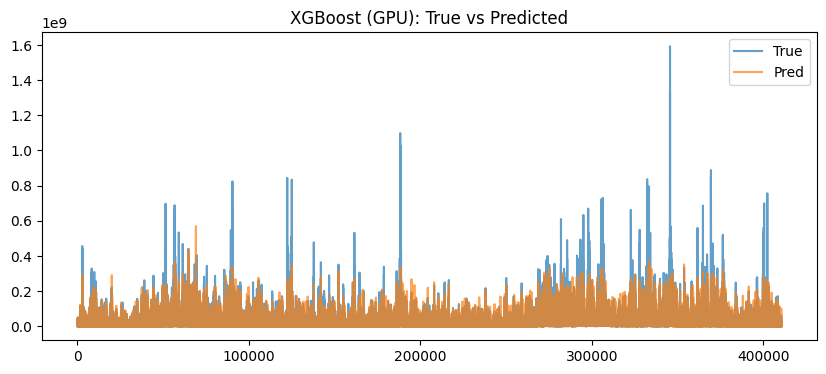

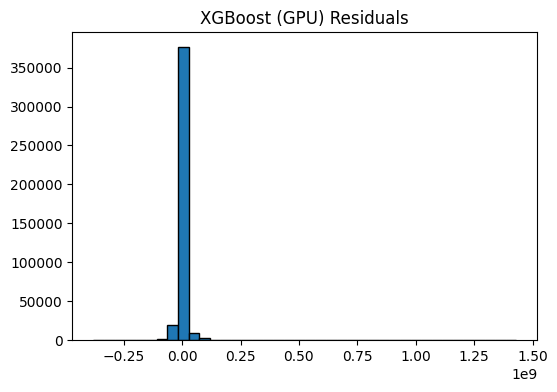

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from tqdm import tqdm
import os
import time

#---------------- winsorize helper ----------------#
def winsorize_array_2d(X, limits=(0.01, 0.01)):
    """
    Apply column-wise winsorization to a 2D array.
    """
    return np.apply_along_axis(lambda col: winsorize(col, limits=limits), 0, X)

#===================== TASK 1: PREP & RF MODEL =====================#
print("1. Load and clean data")
data = pd.read_csv(r"/kaggle/input/crypto-feature/crypto_features_10min.csv", parse_dates=["date"])
print(f" Data shape: {data.shape}")

# Feature engineering
print("2. Feature engineering")
data['vol_diff_30m_60m'] = data['rolling_volume_30min'] - data['rolling_volume_60min']
data['hour'] = data['date'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

numeric_features = [
    'log_return_10min', 'rolling_vol_30min', 'rolling_volume_30min', 'z_volume_30min',
    'rolling_trades_mean_30min', 'z_trades_30min', 'z_close_30min', 'rolling_vol_60min',
    'rolling_volume_60min', 'z_volume_60min', 'rolling_trades_mean_60min', 'z_trades_60min',
    'z_close_60min', 'rolling_vol_120min', 'rolling_volume_120min', 'z_volume_120min',
    'rolling_trades_mean_120min', 'z_trades_120min', 'z_close_120min', 'hl_range',
    'minute_of_day', 'is_morning', 'vol_diff_30m_60m', 'hour_sin', 'hour_cos'
]

categorical_features = ['asset']
target = 'future_volume_1h'

print("3. Subset & fill missing")
data = data.sort_values('date')
# 按明确时间点划分（2023-12-31）
# Time-based train-test split
split_date = "2023-12-31"
X_train = data[data['date'] <= split_date][numeric_features + categorical_features].copy()
X_test = data[data['date'] > split_date][numeric_features + categorical_features].copy()
y_train = data[data['date'] <= split_date][target].copy()
y_test = data[data['date'] > split_date][target].copy()

# Handle missing values using train set stats only
train_means = X_train[numeric_features].mean()
train_median = y_train.median()

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train[numeric_features] = X_train[numeric_features].fillna(train_means)
X_test[numeric_features] = X_test[numeric_features].fillna(train_means)

y_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_test.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.fillna(train_means, inplace=True)
y_test.fillna(train_means, inplace=True)

# Preprocessing pipeline
print("4. Setting up preprocessing")
winsor_tf = FunctionTransformer(winsorize_array_2d, validate=False)
num_pipeline = Pipeline([
    ('winsor', winsor_tf),
    ('scale', RobustScaler())
])
cat_pipeline = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
], n_jobs=-1)


# XGBoost pipeline with GPU
print("6. Building GPU XGBoost pipeline")
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(
        n_estimators=1000,
        max_depth=10,
        min_child_weight=4,
        colsample_bytree=np.sqrt(len(numeric_features) + len(categorical_features)) / (len(numeric_features) + len(categorical_features)),
        tree_method='gpu_hist',
        random_state=42
    ))
])

# Train on GPU
print("7. Training XGBoost pipeline on GPU")
start_time = time.time()
xgb_pipeline.fit(X_train, np.log1p(y_train))
print(f"Training complete in {time.time() - start_time:.2f} seconds")

# Predict on GPU
print("8. Predicting on GPU")
y_pred_xgb = np.expm1(xgb_pipeline.predict(X_test))

# Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("XGBoost (GPU) Results:")
print(f" RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.4f}, MAE: {mae_xgb:.2f}")

# Baseline
baseline_rmse = np.sqrt(((y_test - y_test.mean())**2).mean())
print(f"Baseline (mean) RMSE: {baseline_rmse:.2f}")

#===================== Task 1 Visualizations =====================#
def plot_time_results(y_true, y_pred, dates):
    plt.figure(figsize=(10, 3))
    plt.plot(dates, y_true, label='True',alpha=0.7)
    plt.plot(dates, y_pred, label='Pred', alpha=0.7)
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

test_dates = data[data['date'] > "2023-12-31"]['date']
plot_time_results(y_test, y_pred_xgb, test_dates)

print("9. Plotting XGBoost results")
plot_results(y_test, y_pred_xgb, 'XGBoost (GPU): True vs Predicted')

plt.figure(figsize=(6, 4))
plt.hist(y_test - y_pred_xgb, bins=40, edgecolor='black')
plt.title('XGBoost (GPU) Residuals')
plt.show()

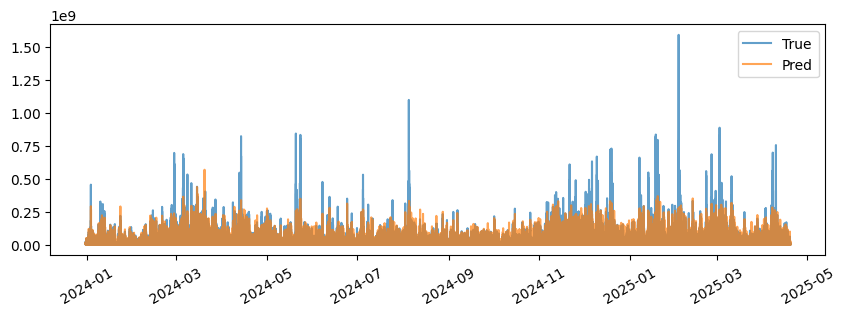

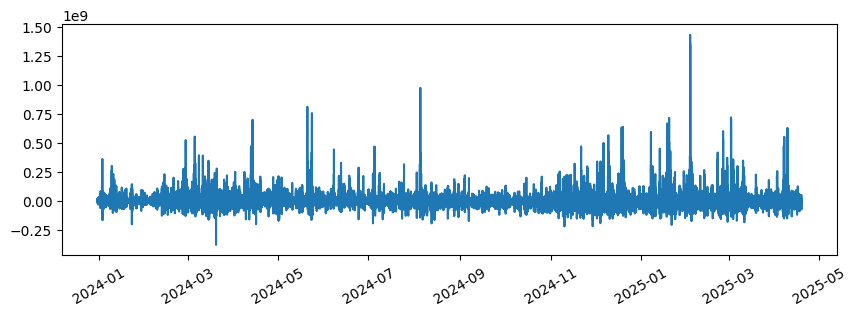

In [16]:

def plot_time_results(y_true, y_pred, dates):
    plt.figure(figsize=(10, 3))
    plt.plot(dates, y_true, label='True', alpha=0.7)
    plt.plot(dates, y_pred, label='Pred', alpha=0.7)
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

test_dates = data[data['date'] > "2023-12-31"]['date']
plot_time_results(y_test, y_pred_xgb, test_dates)
plt.figure(figsize=(10, 3))
plt.plot(test_dates, y_test - y_pred_xgb)
plt.xticks(rotation=30)
plt.show()

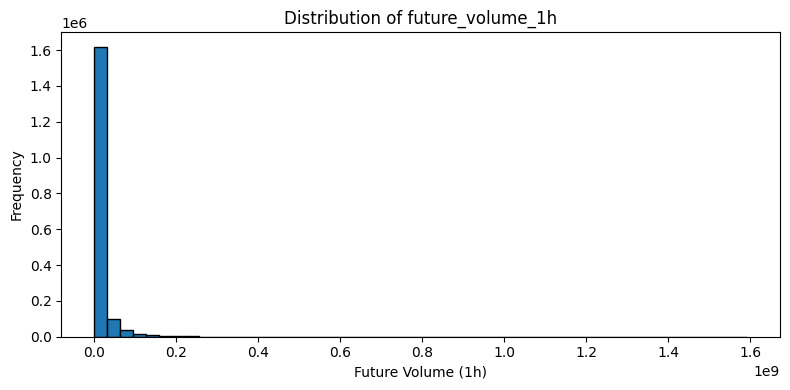

Target statistics:
Skewness: 8.29
Kurtosis: 142.40
Mean: 11315501.35, Median: 2011118.27, Std: 29490629.03


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.stats.mstats import winsorize
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
import shap
from tqdm import tqdm
import os
import time
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import KBinsDiscretizer
# Check target distribution
logger.info("4. Checking target distribution")
plt.figure(figsize=(8, 4))
plt.hist(y, bins=50, edgecolor='black')
plt.title('Distribution of future_volume_1h')
plt.xlabel('Future Volume (1h)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Compute and log summary statistics
print("Target statistics:")
print(f"Skewness: {skew(y):.2f}")
print(f"Kurtosis: {kurtosis(y):.2f}")
print(f"Mean: {y.mean():.2f}, Median: {y.median():.2f}, Std: {y.std():.2f}")
# Handle imbalanced target with binning and weighting
logger.info("5. Handling imbalanced target with binning and weighting")
binner = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
y_bins = binner.fit_transform(y_transformed.reshape(-1, 1)).ravel()

# Compute weights based on inverse bin frequency
bin_counts = np.bincount(y_bins.astype(int))
bin_weights = 1.0 / (bin_counts + 1e-6)
sample_weights = bin_weights[y_bins.astype(int)]

# Split weights for train and test
sample_weights_train = sample_weights[:len(X_train)]
sample_weights_test = sample_weights[len(X_train):]

# Task 2: SHAP Analysi #

In [22]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Define results directory
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# Get feature names after preprocessing
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Use all samples for SHAP
X_test_shap = X_test
X_test_shap_df = pd.DataFrame(X_test_shap, columns=feature_names)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(lgb_model, feature_names=feature_names)

# Compute SHAP values with GPU and progress bar
chunk_size = 10000  # Process 10,000 samples per chunk
chunks = [X_test_shap[i:i + chunk_size] for i in range(0, X_test_shap.shape[0], chunk_size)]

shap_values_chunks = []
for chunk in tqdm(chunks, desc="Computing SHAP values", total=len(chunks)):
    shap_values_chunk = explainer.shap_values(chunk)
    shap_values_chunks.append(shap_values_chunk)

shap_values = np.vstack(shap_values_chunks)

# Save SHAP values with compression
np.savez_compressed(os.path.join(results_dir, "shap_values.npz"), shap_values=shap_values)

# Plot 1: Feature Importance (Mean Absolute SHAP Values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, plot_type="bar", show=False)
plt.title("Feature Importance (Mean SHAP Values)")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_feature_importance.png"))
plt.show()

# Plot 2: SHAP Summary Plot (Distribution of SHAP Values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_summary.png"))
plt.show()

# Plot 3: SHAP Force Plot for a Single Sample
sample_idx = 0
plt.figure(figsize=(10, 4))
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test_shap_df.iloc[sample_idx], matplotlib=True, show=False)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_force_plot.png"))
plt.show()

Computing SHAP values:   0%|          | 0/42 [00:00<?, ?it/s]


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: asset: object

# TASK 3: FEATURE SELECTION & MODEL RETRAINING #

In [23]:
# Feature importance based on mean absolute SHAP values
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': shap_importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Select top 80% of features
top_percent = 0.8
n_features = int(len(feature_importance) * top_percent)
selected_features = feature_importance['feature'].head(n_features).tolist()

# Update preprocessor with selected features
numeric_selected = [f for f in numeric_features if f in selected_features]
cat_selected = [f for f in categorical_features if f in selected_features]
preprocessor_selected = ColumnTransformer([
    ('num', num_pipeline, numeric_selected),
    ('cat', cat_pipeline, cat_selected)
], n_jobs=-1)

# Preprocess data with selected features
X_train_selected = preprocessor_selected.fit_transform(X_train)
X_test_selected = preprocessor_selected.transform(X_test)

# Convert to NumPy arrays
X_train_selected = X_train_selected.toarray() if hasattr(X_train_selected, 'toarray') else X_train_selected
X_test_selected = X_test_selected.toarray() if hasattr(X_test_selected, 'toarray') else X_test_selected

# Retrain XGBoost model with selected features
xgb_model_selected = XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    min_child_weight=4,
    colsample_bytree=np.sqrt(X_train_selected.shape[1]) / X_train_selected.shape[1],
    tree_method='gpu_hist',
    random_state=42
)
xgb_model_selected.fit(X_train_selected, y_train_processed)

# Predict with selected features
y_pred_xgb_selected = np.expm1(xgb_model_selected.predict(X_test_selected))

# Metrics for selected model
rmse_xgb_selected = np.sqrt(mean_squared_error(y_test_processed, y_pred_xgb_selected))
r2_xgb_selected = r2_score(y_test_processed, y_pred_xgb_selected)
mae_xgb_selected = mean_absolute_error(y_test_processed, y_pred_xgb_selected)
print("XGBoost (GPU) with Selected Features Results:")
print(f" RMSE: {rmse_xgb_selected:.2f}, R2: {r2_xgb_selected:.4f}, MAE: {mae_xgb_selected:.2f}")

# Compare performance
print("\nPerformance Comparison:")
print(f"Original Model - RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.4f}, MAE: {mae_xgb:.2f}")
print(f"Selected Model - RMSE: {rmse_xgb_selected:.2f}, R2: {r2_xgb_selected:.4f}, MAE: {mae_xgb_selected:.2f}")


[13:35:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[13:36:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



XGBoost (GPU) with Selected Features Results:
 RMSE: 22248847.02, R2: 0.6045, MAE: 6762512.78

Performance Comparison:
Original Model - RMSE: 22188247.88, R2: 0.6067, MAE: 6794730.23
Selected Model - RMSE: 22248847.02, R2: 0.6045, MAE: 6762512.78


In [21]:
from lightgbm import LGBMRegressor
# XGBoost pipeline with GPU
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lgb', LGBMRegressor(
    n_estimators=200,
    max_depth=10,
    min_child_samples=4,  # Equivalent to min_child_weight in XGBoost
    colsample_bytree=np.sqrt(X_train_processed.shape[1]) / X_train_processed.shape[1],  # Equivalent to max_features='sqrt'
    device='gpu',  # Enable GPU (requires LightGBM with GPU support)
    random_state=42
    ))
])
lgb_pipeline.fit(X_train, np.log1p(y_train))
y_pred_lgb = np.expm1(lgb_pipeline.predict(X_test))

# Metrics
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
print("XGBoost (GPU) Results:")
print(f" RMSE: {rmse_lgb:.2f}, R2: {r2_lgb:.4f}, MAE: {mae_lgb:.2f}")

# Baseline
baseline_rmse = np.sqrt(((y_test - y_test.mean())**2).mean())
print(f"Baseline (mean) RMSE: {baseline_rmse:.2f}")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5549
[LightGBM] [Info] Number of data points in the train set: 1378775, number of used features: 31
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (36.82 MB) transferred to GPU in 0.041424 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14.525696
XGBoost (GPU) Results:
 RMSE: 21695720.23, R2: 0.6240, MAE: 6871977.59
Baseline (mean) RMSE: 35379931.07


# Lightboost

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5549
[LightGBM] [Info] Number of data points in the train set: 1378775, number of used features: 31
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (36.82 MB) transferred to GPU in 0.036005 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14.525696
LightGBM (GPU) Results:
 RMSE: 21695720.19, R2: 0.6240, MAE: 6871977.56
Baseline (mean) RMSE: 35379931.07


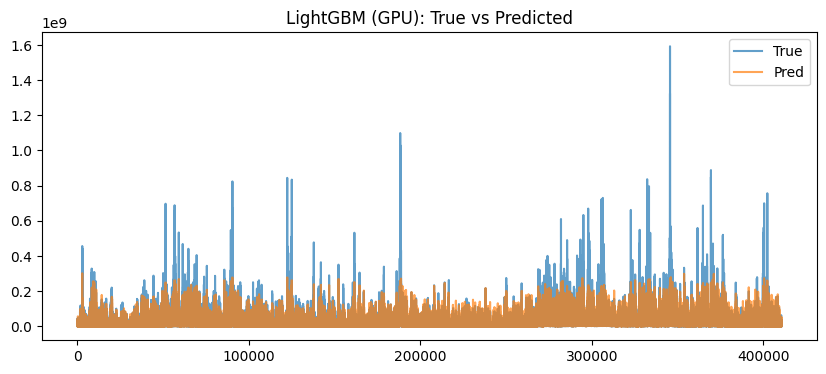

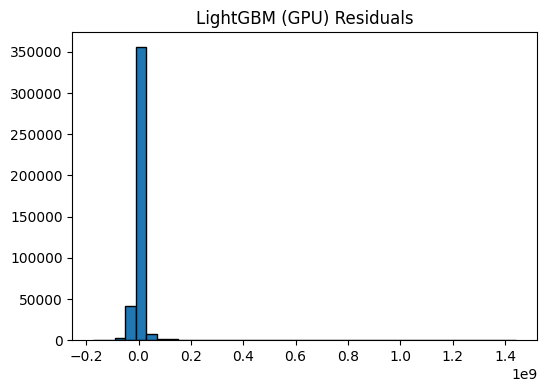

Computing SHAP values: 100%|██████████| 42/42 [03:03<00:00,  4.36s/it]


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4496
[LightGBM] [Info] Number of data points in the train set: 1378775, number of used features: 19
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 19 dense feature groups (26.30 MB) transferred to GPU in 0.032540 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14.525696
LightGBM (GPU) with Selected Features Results:
 RMSE: 21795580.00, R2: 0.6205, MAE: 7165483.87

Performance Comparison:
Original Model - RMSE: 21695720.19, R2: 0.6240, MAE: 6871977.56
Selected Model - RMSE: 21795580.00, R2: 0.6205, MAE: 7165483.87


<Figure size 1000x400 with 0 Axes>

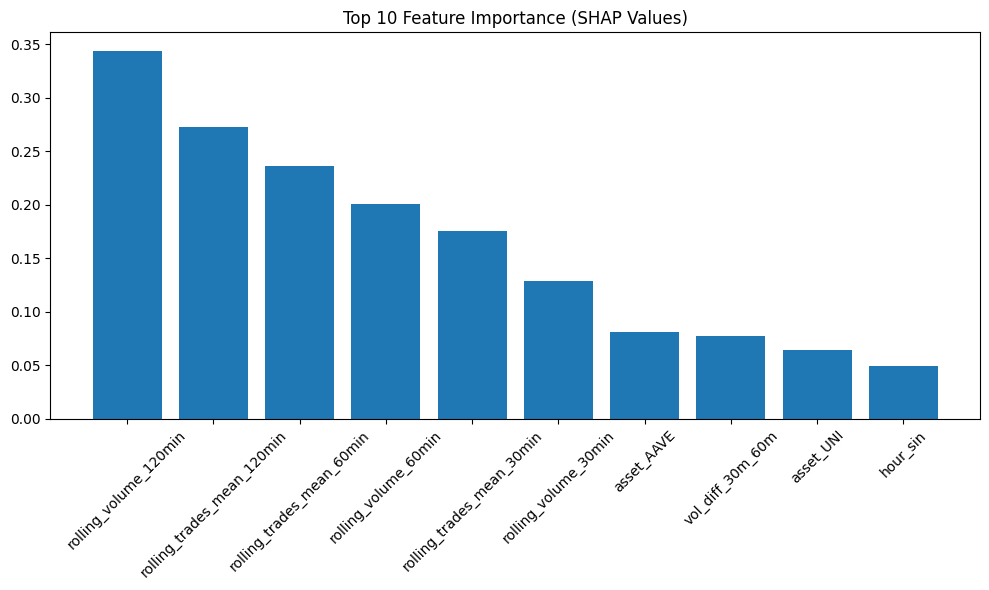

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.stats.mstats import winsorize
from lightgbm import LGBMRegressor  # 替换 XGBoost
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from tqdm import tqdm
import os
import time


# Preprocess data
logger.info("6. Preprocessing data")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to NumPy arrays for LightGBM
X_train_processed = X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed
X_test_processed = X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed
y_train_processed = np.log1p(y_train.values)
y_test_processed = y_test.values

# LightGBM pipeline with GPU
logger.info("7. Building GPU LightGBM pipeline")
lgb_model = LGBMRegressor(
    n_estimators=1000,
    max_depth=10,
    min_child_samples=4,  # Equivalent to min_child_weight in XGBoost
    colsample_bytree=np.sqrt(X_train_processed.shape[1]) / X_train_processed.shape[1],  # Equivalent to max_features='sqrt'
    device='gpu',  # Enable GPU (requires LightGBM with GPU support)
    random_state=42
)

# Train on GPU
logger.info("8. Training LightGBM model on GPU")
start_time = time.time()
lgb_model.fit(X_train_processed, y_train_processed)
logger.info(f"Training complete in {time.time() - start_time:.2f} seconds")

# Predict on GPU
logger.info("9. Predicting on GPU")
y_pred_lgb = np.expm1(lgb_model.predict(X_test_processed))

# Metrics
rmse_lgb = np.sqrt(mean_squared_error(y_test_processed, y_pred_lgb))
r2_lgb = r2_score(y_test_processed, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test_processed, y_pred_lgb)
print("LightGBM (GPU) Results:")
print(f" RMSE: {rmse_lgb:.2f}, R2: {r2_lgb:.4f}, MAE: {mae_lgb:.2f}")

# Baseline
baseline_rmse = np.sqrt(((y_test - y_test.mean())**2).mean())
print(f"Baseline (mean) RMSE: {baseline_rmse:.2f}")

#===================== Task 1 Visualizations =====================#
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.values, label='True', alpha=0.7)
    plt.plot(y_pred, label='Pred', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

logger.info("10. Plotting LightGBM results")
plot_results(y_test, y_pred_lgb, 'LightGBM (GPU): True vs Predicted')

plt.figure(figsize=(6, 4))
plt.hist(y_test - y_pred_lgb, bins=40, edgecolor='black')
plt.title('LightGBM (GPU) Residuals')
plt.show()

#===================== Task 2: SHAP Analysis =====================#
# Define results directory
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# Get feature names after preprocessing
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
logger.info(f"Total features for SHAP: {len(feature_names)}")

# Use all samples for SHAP
X_test_shap = X_test_processed
X_test_shap_df = pd.DataFrame(X_test_shap, columns=feature_names)
logger.info(f"Using {X_test_shap.shape[0]} samples for SHAP analysis")

# Initialize SHAP TreeExplainer
logger.info("Initializing SHAP TreeExplainer")
start_time = time.time()
explainer = shap.TreeExplainer(lgb_model, feature_names=feature_names)
logger.info(f"SHAP TreeExplainer initialized in {time.time() - start_time:.2f} seconds")

# Compute SHAP values with GPU and progress bar
logger.info("Computing SHAP values with GPU")
start_time = time.time()

# Split data into chunks for memory management
chunk_size = 10000  # Process 10,000 samples per chunk
chunks = [X_test_shap[i:i + chunk_size] for i in range(0, X_test_shap.shape[0], chunk_size)]
logger.info(f"Total chunks to process: {len(chunks)}")

shap_values_chunks = []
for chunk in tqdm(chunks, desc="Computing SHAP values", total=len(chunks)):
    shap_values_chunk = explainer.shap_values(chunk)
    shap_values_chunks.append(shap_values_chunk)

shap_values = np.vstack(shap_values_chunks)
logger.info(f"SHAP values computed in {time.time() - start_time:.2f} seconds")

# Save SHAP values with compression
logger.info("Saving SHAP values")
np.savez_compressed(os.path.join(results_dir, "shap_values.npz"), shap_values=shap_values)
logger.info("SHAP values saved to results/shap_values.npz")

# Plot 1: Feature Importance (Mean Absolute SHAP Values)
logger.info("Generating SHAP feature importance plot")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, plot_type="bar", show=False)
plt.title("Feature Importance (Mean SHAP Values)")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_feature_importance.png"))
plt.close()
logger.info("SHAP feature importance plot saved to results/shap_feature_importance.png")

# Plot 2: SHAP Summary Plot (Distribution of SHAP Values)
logger.info("Generating SHAP summary plot")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_summary.png"))
plt.close()
logger.info("SHAP summary plot saved to results/shap_summary.png")

# Plot 3: SHAP Force Plot for a Single Sample
logger.info("Generating SHAP force plot for a single sample")
sample_idx = 0
plt.figure(figsize=(10, 4))
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test_shap_df.iloc[sample_idx], matplotlib=True, show=False)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_force_plot.png"))
plt.close()
logger.info("SHAP force plot saved to results/shap_force_plot.png")

#===================== TASK 3: FEATURE SELECTION & MODEL RETRAINING =====================#
logger.info("11. Feature selection based on SHAP values")
# Feature importance based on mean absolute SHAP values
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': shap_importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Select top 80% of features
top_percent = 0.8
n_features = int(len(feature_importance) * top_percent)
selected_features = feature_importance['feature'].head(n_features).tolist()
logger.info(f"Selected {len(selected_features)} features out of {len(feature_names)}")

# Update preprocessor with selected features
numeric_selected = [f for f in numeric_features if f in selected_features]
cat_selected = [f for f in categorical_features if f in selected_features]
preprocessor_selected = ColumnTransformer([
    ('num', num_pipeline, numeric_selected),
    ('cat', cat_pipeline, cat_selected)
], n_jobs=-1)

# Preprocess data with selected features
logger.info("12. Preprocessing with selected features")
X_train_selected = preprocessor_selected.fit_transform(X_train)
X_test_selected = preprocessor_selected.transform(X_test)

# Convert to NumPy arrays
X_train_selected = X_train_selected.toarray() if hasattr(X_train_selected, 'toarray') else X_train_selected
X_test_selected = X_test_selected.toarray() if hasattr(X_test_selected, 'toarray') else X_test_selected

# Retrain LightGBM model with selected features
logger.info("13. Retraining LightGBM model with selected features on GPU")
lgb_model_selected = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    min_child_samples=4,
    colsample_bytree=np.sqrt(X_train_selected.shape[1]) / X_train_selected.shape[1],
    device='gpu',  # Enable GPU
    random_state=42
)
start_time = time.time()
lgb_model_selected.fit(X_train_selected, y_train_processed)
logger.info(f"Retraining complete in {time.time() - start_time:.2f} seconds")

# Predict with selected features
logger.info("14. Predicting with selected features on GPU")
y_pred_lgb_selected = np.expm1(lgb_model_selected.predict(X_test_selected))

# Metrics for selected model
rmse_lgb_selected = np.sqrt(mean_squared_error(y_test_processed, y_pred_lgb_selected))
r2_lgb_selected = r2_score(y_test_processed, y_pred_lgb_selected)
mae_lgb_selected = mean_absolute_error(y_test_processed, y_pred_lgb_selected)
print("LightGBM (GPU) with Selected Features Results:")
print(f" RMSE: {rmse_lgb_selected:.2f}, R2: {r2_lgb_selected:.4f}, MAE: {mae_lgb_selected:.2f}")

# Compare performance
logger.info("15. Comparing performance")
print("\nPerformance Comparison:")
print(f"Original Model - RMSE: {rmse_lgb:.2f}, R2: {r2_lgb:.4f}, MAE: {mae_lgb:.2f}")
print(f"Selected Model - RMSE: {rmse_lgb_selected:.2f}, R2: {r2_lgb_selected:.4f}, MAE: {mae_lgb_selected:.2f}")

# Optional: Plot feature importance
logger.info("16. Plotting feature importance")
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45)
plt.title("Top 10 Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()

# 尝试处理极端值问题

In [19]:
# 在 Task 1 训练部分添加
weights = np.where(y_train_processed > np.percentile(y_train_processed, 90), 2.0, 1.0)
logger.info("7. Building GPU XGBoost pipeline with weighted samples")
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=15,
    min_child_weight=4,
    colsample_bytree=0.9,
    tree_method='gpu_hist',
    learning_rate=0.1,
    random_state=42
)

logger.info("8. Training XGBoost model on GPU with weights")
start_time = time.time()
xgb_model.fit(X_train_processed, y_train_processed, sample_weight=weights)
logger.info(f"Training complete in {time.time() - start_time:.2f} seconds")

[12:04:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [21]:
# 假设已有的 imports 和数据预处理部分不变，添加 Prophet 相关代码
from prophet import Prophet

# Step 1: Prepare data for Prophet
logger.info("Preparing data for Prophet")
prophet_data = data[['date', 'future_volume_1h']].copy()
prophet_data.rename(columns={'date': 'ds', 'future_volume_1h': 'y'}, inplace=True)
prophet_train = prophet_data.iloc[:n_train].copy()
prophet_test = prophet_data.iloc[n_train:].copy()

# Step 2: Train Prophet model
logger.info("Training Prophet model")
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative'  # Suitable for volatile data like trading volume
)
prophet_model.fit(prophet_train)

# Step 3: Predict with Prophet
logger.info("Predicting with Prophet")
future_dates = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='10min')
prophet_forecast = prophet_model.predict(future_dates)
prophet_pred_train = prophet_forecast['yhat'].iloc[:n_train].values
prophet_pred_test = prophet_forecast['yhat'].iloc[n_train:].values

# Step 4: Compute residuals
logger.info("Computing residuals")
y_train_residuals = y_train_processed - prophet_pred_train
y_test_residuals = y_test_processed - prophet_pred_test

# Step 5: Train XGBoost on residuals
logger.info("Training XGBoost on residuals")
xgb_residual_model = XGBRegressor(
    n_estimators=100,
    max_depth=10,
    min_child_weight=4,
    colsample_bytree=np.sqrt(X_train_processed.shape[1]) / X_train_processed.shape[1],
    tree_method='gpu_hist',
    random_state=42
)
start_time = time.time()
xgb_residual_model.fit(X_train_processed, y_train_residuals)
logger.info(f"XGBoost residual training complete in {time.time() - start_time:.2f} seconds")

# Step 6: Predict residuals with XGBoost
logger.info("Predicting residuals with XGBoost")
y_pred_residuals = xgb_residual_model.predict(X_test_processed)

# Step 7: Combine predictions
logger.info("Combining Prophet and XGBoost predictions")
y_pred_combined = np.expm1(prophet_pred_test + y_pred_residuals)

# Step 8: Metrics for combined model
rmse_combined = np.sqrt(mean_squared_error(y_test_processed, y_pred_combined))
r2_combined = r2_score(y_test_processed, y_pred_combined)
mae_combined = mean_absolute_error(y_test_processed, y_pred_combined)
print("Prophet + XGBoost (GPU) Combined Results:")
print(f" RMSE: {rmse_combined:.2f}, R2: {r2_combined:.4f}, MAE: {mae_combined:.2f}")

# Step 9: Visualize results
def plot_results(y_true, y_pred, title, dates):
    plt.figure(figsize=(10, 4))
    plt.plot(dates.iloc[:len(y_true)], y_true, label='True', alpha=0.7)
    plt.plot(dates.iloc[:len(y_pred)], y_pred, label='Pred', alpha=0.7)
    plt.xlabel('Date')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

logger.info("Plotting combined results")
plot_results(y_test_processed, y_pred_combined, 'Prophet + XGBoost (GPU): True vs Predicted', data['date'].iloc[n_train:])

12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:23 - cmdstanpy - INFO - Chain [1] done processing


ValueError: operands could not be broadcast together with shapes (1431589,) (740518,) 